In [ ]:
# # df = pd.read_csv('aggregated_hourly.csv')
# # #for every distinct device_id create a new column target with the value of WIFI shiftied by 1
# # df['target'] = 0
# # for i in df['device_id'].unique():
# #     df.loc[df['device_id'] == i, 'target'] = df.loc[df['device_id'] == i, 'WIFI'].shift(-1)
# # df.sort_values(by=['date_time'], inplace=True)
# # #drop
# # df = df.dropna()   
# # #onehot encode device_id into int
# # df = pd.get_dummies(df, columns=['device_id'], prefix = 'device_id')
# # #delete date_time column and device_id column
# # df = df.drop(columns=['date_time'])
# # df
# X = df.drop(columns=['target']).astype('float32')
# y = df['target'].astype('float32')
# X = torch.tensor(X.values).float()
# y = torch.tensor(y.values).float()
# print(X.shape)  
# print(y.shape)
# X_new = []
# window_size = 500
# #for i in range(0, len(X), window_size):
# for i in range(0, len(X)):
#     if i < window_size:
#         number_of_padding = window_size - i
#         padding = torch.zeros(number_of_padding, X.shape[1])
#         X_new.append(torch.cat((padding, X[:i])))
#     else:
#         X_new.append(X[i-window_size:i])
# X_new = torch.stack(X_new)
# X_new = X_new[1:]
# X_new.shape

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import main.dataprep as dp

In [2]:
df = pd.read_csv('main/aggregated_hourly.csv')
a0 = ["hka-aqm-a017", "hka-aqm-a014"]
a1 = ["hka-aqm-a101", "hka-aqm-a102", "hka-aqm-a103", "hka-aqm-a106", "hka-aqm-a107", "hka-aqm-a108", "hka-aqm-a111", "hka-aqm-a112"]
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_cutoff = df.copy
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_mean = dp.build_lvl_df(df_cutoff, a1, ["tmp", "hum", "CO2", "VOC"], reset_ind= True)

In [3]:
X = df_mean.to_numpy()
y = df_mean["tmp"].shift(-1).to_numpy()
X_train, X_test, y_train, y_test = dp.train_test_split(X, y,train_size=0.95)
X_train_new, X_test_new = dp.format_tensor(X_train,window_size=100), dp.format_tensor(X_test,window_size=100)
y_train = y_train[:-1]#.unsqueeze(1)
y_test = y_test[:-1]#.unsqueeze(1)
X_train_new.shape, X_test_new.shape, y_train.shape, y_test.shape

(torch.Size([1685, 100, 4]),
 torch.Size([88, 100, 4]),
 torch.Size([1685]),
 torch.Size([88]))

In [4]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_data = TensorDataset(X_train_new, y_train)
test_data = TensorDataset(X_test_new, y_test)

#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [5]:
class PositionalEncoding(torch.nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len,device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient
        pos = torch.arange(0, max_len,device=device)
        pos = pos.float().unsqueeze(dim=1)
        # # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        #batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding
        #return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]         

In [6]:
class ScaledDotProduct(torch.nn.Module):
    """
    scaled dot product attention class
    """
    def __init__(self):
        """
        constructor of scaled dot product attention class
        """
        super(ScaledDotProduct, self).__init__()
        
    def forward(self, Q, K, V, mask=None):
        """
        forward pass of scaled dot product attention
        :param Q: query tensor
        :param K: key tensor
        :param V: value tensor
        :param mask: mask tensor
        :return: output tensor
        """
        d_k = K.size(-1)
        # get dimension of key
        scores = (Q @ K.transpose(-2, -1)) / np.sqrt(d_k)
        # compute attention score
        # if mask is not None:
        #     scores = scores.masked_fill(mask == 0, -1e9)
        #     # apply mask to score
        attention = torch.nn.functional.softmax(scores, dim=-1)
        # apply softmax to score
        output = attention @ V
        # compute output tensor
        return output, attention

In [7]:
class MultiHeadAttention(torch.nn.Module):
    """
    multihead attention class
    """
    def __init__(self, d_model, num_heads):
        """
        constructor of multihead attention class

        :param d_model: dimension of model
        :param num_heads: number of head in multihead attention
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads

        self.d_k = d_model // num_heads
        # get dimension of key

        self.W_Q = torch.nn.Linear(d_model, d_model)
        self.W_K = torch.nn.Linear(d_model, d_model)
        self.W_V = torch.nn.Linear(d_model, d_model)
        # linear transformation for query, key, value

        self.scaled_dot_product = ScaledDotProduct()
        # scaled dot product attention

        self.linear = torch.nn.Linear(d_model, d_model)
        # linear transformation for output

    def forward(self, Q, K, V, mask=None):
        """
        forward pass of multihead attention

        :param Q: query tensor
        :param K: key tensor
        :param V: value tensor
        :param mask: mask tensor
        :return: output tensor
        """
        batch_size = Q.size(0)
        # get batch size

        Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        # linear transformation and split into multihead

        if mask is not None:
            mask = mask.unsqueeze(1)
            # unsqueeze mask

        output, attention = self.scaled_dot_product(Q, K, V, mask)
        # scaled dot product attention

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        # concatenate multihead attention

        return self.linear(output), attention

In [8]:
class Decoder(torch.nn.Module):
    """
    decoder layer class
    """
    def __init__(self, input,d_model,max_len,num_heads,d_ff,device):
        """
        constructor of decoder layer

        :param d_model: dimension of model
        :param num_heads: number of head in multihead attention
        :param d_ff: dimension of feed forward layer
        :param dropout: dropout rate
        """
        super(Decoder, self).__init__()

        self.embed = torch.nn.Linear(input, d_model).to(device)
        self.positonal_encoding = PositionalEncoding(d_model, max_len=max_len,device=device).to(device)
        self.norm = torch.nn.LayerNorm(d_model).to(device)
        self.dropout = torch.nn.Dropout(0.2).to(device)
        self.attn = MultiHeadAttention(d_model, num_heads).to(device)
        self.norm_2 = torch.nn.LayerNorm(d_model).to(device)
        self.linear1 = torch.nn.Linear(d_model, d_model).to(device)
        self.Relu = torch.nn.SELU().to(device)
        self.attn2 = MultiHeadAttention(d_model, num_heads).to(device)
        self.norm_3 = torch.nn.LayerNorm(d_model).to(device)
        self.linear2 = torch.nn.Linear(d_model, d_model).to(device)
        self.attn3 = MultiHeadAttention(d_model, num_heads).to(device)
        self.ff = torch.nn.Sequential(
            torch.nn.LayerNorm(d_model),
            torch.nn.Linear(d_model, d_ff),
            torch.nn.SELU(),
            torch.nn.Linear(d_ff, 1)
        ).to(device)

    def forward(self, x):
        """
        forward pass of decoder layer

        :param x: input tensor (query)
        :param memory: input tensor (key, value)
        :param src_mask: source mask
        :param tgt_mask: target mask
        :return: output tensor
        """
        x = self.embed(x)
        x = x + self.positonal_encoding(x)
        x_norm = self.norm(x)
        x_att, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + x_att
        x = self.dropout(x)
        x = self.norm_2(x)
        x_att2, _ = self.attn2(x, x, x)
        x_att2 = self.linear1(x_att2)
        x_att2 = self.Relu(x_att2)
        x = x + x_att2
        x = self.dropout(x)
        x = self.norm_3(x)
        x_att3, _ = self.attn3(x, x, x)
        x_att3 = self.linear2(x_att3)
        x_att3 = self.Relu(x_att3)
        x = x + x_att3
        x = self.ff(x) #shape am ende noch (500,1), soll des so ?
        return x[:, -1].squeeze()

In [9]:
class SimplifiedDecoder(torch.nn.Module):
    """
    Simplified decoder layer class
    """
    def __init__(self, input, d_model, max_len, num_heads, d_ff, device):
        """
        Constructor of simplified decoder layer

        :param d_model: dimension of model
        :param num_heads: number of head in multihead attention
        :param d_ff: dimension of feed forward layer
        """
        super(SimplifiedDecoder, self).__init__()

        self.embed = torch.nn.Linear(input, d_model).to(device)
        self.positonal_encoding = PositionalEncoding(d_model, max_len=max_len, device=device).to(device)
        self.norm = torch.nn.LayerNorm(d_model).to(device)
        self.dropout = torch.nn.Dropout(0.2).to(device)
        self.attn = MultiHeadAttention(d_model, num_heads).to(device)
        self.ff = torch.nn.Sequential(
            torch.nn.LayerNorm(d_model),
            torch.nn.Linear(d_model, d_ff),
            torch.nn.SELU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(d_ff,d_model),
            torch.nn.SELU(),
            torch.nn.Linear(d_model, 1)
        ).to(device)

    def forward(self, x):
        """
        Forward pass of simplified decoder layer

        :param x: input tensor (query)
        :return: output tensor
        """
        x = self.embed(x)
        x = x + self.positonal_encoding(x)
        x_norm = self.norm(x)
        x_att, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + x_att
        x = self.dropout(x)
        x = self.ff(x)
        return x[:, -1].squeeze()

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Decoder1 = Decoder(data[0][0].shape[1], 32,max_len=data[0][0].shape[0],num_heads=4,d_ff=128,device=device)
# d = Decoder1.forward(x)

In [22]:
df = pd.read_csv('aggregated_hourly.csv')
a0 = "hka-aqm-a017"
a1 = "hka-aqm-a101"
df = df[df["device_id"] == a0]
df = df[["tmp", "hum", "CO2", "VOC"]+["date_time"]]
min_date = df['date_time'].min()
max_date = df['date_time'].max()
hourly_range = pd.date_range(start=min_date, end=max_date, freq='h')
missing_hours = hourly_range[~hourly_range.isin(df['date_time'])]
df.date_time = pd.to_datetime(df.date_time)
for i in missing_hours:
    #df.date_time = pd.to_datetime(df.date_time)
    df_temp = df.loc[df["date_time"] < i][["tmp", "hum", "CO2", "VOC"]].copy()
    df_temp = df_temp.astype(float)
    df_temp_values = df_temp.values
    if len(df_temp_values) <= 100:
        X = torch.stack([torch.cat((torch.zeros(100-len(df_temp_values), df_temp_values.shape[1]), torch.from_numpy(df_temp_values)), dim=0)]).float()
    else:
        X = torch.stack([torch.from_numpy(df_temp_values[-100:])]).float()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Decoder(input=len(["tmp", "hum", "CO2", "VOC"]),d_model=128,max_len=100,num_heads=4,d_ff=120,device='cpu')
    model.load_state_dict(torch.load('Decoder1.pth'))
    model.float()
    model.eval()
    y_pred = model(X)
    print(y_pred)
    new_row = df_temp.iloc[-1].copy()
    columns = ["tmp", "hum", "CO2", "VOC"]
    new_row.at['date_time'] = i
    index_of_tmp = columns.index("tmp")
    new_row[index_of_tmp] = y_pred.item()
    new_row_series = pd.Series(new_row, index=df.columns)
    df = pd.concat([df, new_row_series.to_frame().T], ignore_index=True)
    

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:9: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



tensor(21.7455, grad_fn=<SqueezeBackward0>)
tensor(23.2865, grad_fn=<SqueezeBackward0>)
tensor(21.4462, grad_fn=<SqueezeBackward0>)
tensor(21.7330, grad_fn=<SqueezeBackward0>)
tensor(21.3177, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(21.5483, grad_fn=<SqueezeBackward0>)
tensor(21.7549, grad_fn=<SqueezeBackward0>)
tensor(21.9174, grad_fn=<SqueezeBackward0>)
tensor(21.9728, grad_fn=<SqueezeBackward0>)
tensor(21.9257, grad_fn=<SqueezeBackward0>)
tensor(22.0045, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(22.4162, grad_fn=<SqueezeBackward0>)
tensor(22.8449, grad_fn=<SqueezeBackward0>)
tensor(23.7046, grad_fn=<SqueezeBackward0>)
tensor(24.0919, grad_fn=<SqueezeBackward0>)
tensor(24.4977, grad_fn=<SqueezeBackward0>)
tensor(24.9441, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.9375, grad_fn=<SqueezeBackward0>)
tensor(23.6936, grad_fn=<SqueezeBackward0>)
tensor(23.6943, grad_fn=<SqueezeBackward0>)
tensor(24.0641, grad_fn=<SqueezeBackward0>)
tensor(24.1318, grad_fn=<SqueezeBackward0>)
tensor(24.1749, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.2211, grad_fn=<SqueezeBackward0>)
tensor(24.2514, grad_fn=<SqueezeBackward0>)
tensor(24.2768, grad_fn=<SqueezeBackward0>)
tensor(24.2979, grad_fn=<SqueezeBackward0>)
tensor(24.3183, grad_fn=<SqueezeBackward0>)
tensor(24.3367, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.3547, grad_fn=<SqueezeBackward0>)
tensor(24.3729, grad_fn=<SqueezeBackward0>)
tensor(24.3920, grad_fn=<SqueezeBackward0>)
tensor(24.4099, grad_fn=<SqueezeBackward0>)
tensor(24.4250, grad_fn=<SqueezeBackward0>)
tensor(24.4396, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.4549, grad_fn=<SqueezeBackward0>)
tensor(24.4686, grad_fn=<SqueezeBackward0>)
tensor(24.4818, grad_fn=<SqueezeBackward0>)
tensor(24.4938, grad_fn=<SqueezeBackward0>)
tensor(24.5049, grad_fn=<SqueezeBackward0>)
tensor(24.5147, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5232, grad_fn=<SqueezeBackward0>)
tensor(24.5311, grad_fn=<SqueezeBackward0>)
tensor(24.5388, grad_fn=<SqueezeBackward0>)
tensor(24.5463, grad_fn=<SqueezeBackward0>)
tensor(24.5536, grad_fn=<SqueezeBackward0>)
tensor(24.5609, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5679, grad_fn=<SqueezeBackward0>)
tensor(24.5768, grad_fn=<SqueezeBackward0>)
tensor(24.6263, grad_fn=<SqueezeBackward0>)
tensor(24.6459, grad_fn=<SqueezeBackward0>)
tensor(24.6637, grad_fn=<SqueezeBackward0>)
tensor(24.6779, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.6861, grad_fn=<SqueezeBackward0>)
tensor(24.7045, grad_fn=<SqueezeBackward0>)
tensor(24.7127, grad_fn=<SqueezeBackward0>)
tensor(24.7293, grad_fn=<SqueezeBackward0>)
tensor(24.7381, grad_fn=<SqueezeBackward0>)
tensor(24.7538, grad_fn=<SqueezeBackward0>)
tensor(24.7627, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.7697, grad_fn=<SqueezeBackward0>)
tensor(24.7770, grad_fn=<SqueezeBackward0>)
tensor(24.7834, grad_fn=<SqueezeBackward0>)
tensor(24.7888, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.7934, grad_fn=<SqueezeBackward0>)
tensor(24.7978, grad_fn=<SqueezeBackward0>)
tensor(24.8032, grad_fn=<SqueezeBackward0>)
tensor(24.8102, grad_fn=<SqueezeBackward0>)
tensor(24.8172, grad_fn=<SqueezeBackward0>)
tensor(24.8247, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.8321, grad_fn=<SqueezeBackward0>)
tensor(24.8400, grad_fn=<SqueezeBackward0>)
tensor(24.8572, grad_fn=<SqueezeBackward0>)
tensor(24.8713, grad_fn=<SqueezeBackward0>)
tensor(24.8810, grad_fn=<SqueezeBackward0>)
tensor(24.8890, grad_fn=<SqueezeBackward0>)
tensor(24.8976, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.9062, grad_fn=<SqueezeBackward0>)
tensor(24.9170, grad_fn=<SqueezeBackward0>)
tensor(24.9336, grad_fn=<SqueezeBackward0>)
tensor(24.9475, grad_fn=<SqueezeBackward0>)
tensor(24.9577, grad_fn=<SqueezeBackward0>)
tensor(24.9654, grad_fn=<SqueezeBackward0>)
tensor(24.9740, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.9829, grad_fn=<SqueezeBackward0>)
tensor(24.9926, grad_fn=<SqueezeBackward0>)
tensor(25.0071, grad_fn=<SqueezeBackward0>)
tensor(25.0251, grad_fn=<SqueezeBackward0>)
tensor(24.9787, grad_fn=<SqueezeBackward0>)
tensor(24.9954, grad_fn=<SqueezeBackward0>)
tensor(24.9993, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.9344, grad_fn=<SqueezeBackward0>)
tensor(24.9101, grad_fn=<SqueezeBackward0>)
tensor(24.8956, grad_fn=<SqueezeBackward0>)
tensor(24.9028, grad_fn=<SqueezeBackward0>)
tensor(24.8981, grad_fn=<SqueezeBackward0>)
tensor(24.9020, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.9031, grad_fn=<SqueezeBackward0>)
tensor(24.9150, grad_fn=<SqueezeBackward0>)
tensor(24.8800, grad_fn=<SqueezeBackward0>)
tensor(24.5501, grad_fn=<SqueezeBackward0>)
tensor(24.5491, grad_fn=<SqueezeBackward0>)
tensor(24.5490, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5489, grad_fn=<SqueezeBackward0>)
tensor(24.5488, grad_fn=<SqueezeBackward0>)
tensor(24.5487, grad_fn=<SqueezeBackward0>)
tensor(24.5486, grad_fn=<SqueezeBackward0>)
tensor(24.5485, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5479, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5480, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5481, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5481, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5482, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5482, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)
tensor(24.5483, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)
tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarni

tensor(24.5484, grad_fn=<SqueezeBackward0>)


C:\Users\paulh\AppData\Local\Temp\ipykernel_24816\3182505711.py:31: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`



In [26]:
df.loc[df.date_time.isin(missing_hours),"richtig"] = 1

In [27]:
import plotly.express as px
px.scatter(df, x='date_time', y='tmp',color="richtig")

In [33]:
def evaluate_model(model, columns, window_size, device_id):
    """
    args:   model: torch.nn.Module
            columns: on which columns the model was trained
            window_size: lookback window size
            device_id: Room

    returns: dataframe
    """
    if model == "lstm":
        #model = LSTM(input_size=len(columns), hidden_size=128, num_layers=2, output_size=1)
        print("not implemented")
    elif model == "rnn":
        #model = RNN(input_size=len(columns), hidden_size=128, num_layers=2, output_size=1)
        print("not implemented")
    elif model == "transformer":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = Decoder(input=len(columns),d_model=128,max_len=window_size,num_heads=4,d_ff=120,device=device)
        model.load_state_dict(torch.load('Decoder1.pth'))
        model.float()
    df = pd.read_csv('aggregated_hourly.csv')
    df = df[df["device_id"] == device_id]
    df = df[columns+["date_time"]]
    min_date = df['date_time'].min()
    max_date = df['date_time'].max()
    hourly_range = pd.date_range(start=min_date, end=max_date, freq='H')
    missing_hours = hourly_range[~hourly_range.isin(df['date_time'])]
    df.date_time = pd.to_datetime(df.date_time)
    for i in missing_hours:
        df_temp = df.loc[df["date_time"] < i][columns].copy()
        df_temp = df_temp.astype(float)
        df_temp_values = df_temp.values
        print(df_temp_values.shape)
        if len(df_temp_values) <= window_size:
            X = torch.stack([torch.cat((torch.zeros(window_size-len(df_temp_values), df_temp_values.shape[1]), torch.from_numpy(df_temp_values)), dim=0)]).float()
        else:
            X = torch.stack([torch.from_numpy(df_temp_values[-window_size:])]).float()
        model.eval()
        y_pred = model(X)
        new_row = df_temp.iloc[-1].copy()
        new_row.at['date_time'] = i
        index_of_tmp = columns.index("tmp")
        new_row[index_of_tmp] = y_pred.item()
        new_row_series = pd.Series(new_row, index=df.columns)
        df = pd.concat([df, new_row_series.to_frame().T], ignore_index=True)
    return df
        

In [181]:
# Train Decoder
from torch.optim import Adam
from torch.nn import MSELoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a Decoder
Decoder1 = Decoder(train_data[0][0].shape[1], 128,max_len=train_data[0][0].shape[0],num_heads=4,d_ff=256,device=device)

# Create a Loss Function
criterion = MSELoss()

# Create an Optimizer
optimizer = Adam(Decoder1.parameters(), lr=0.001)

In [185]:
# Train the Decoder
import torch
import time

# Move model to GPU
Decoder1 = Decoder1.to(device)

# Define the number of epochs
num_epochs = 200

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Decoder1.parameters(), lr=0.0009
)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

Decoder1.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        # Move tensors to GPU
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        output = Decoder1(x)
        loss = criterion(output, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Decay the learning rate
    scheduler.step()

    print(f'Epoch: {epoch + 1:03d}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch: 001, Loss: 8.4779, Learning Rate: 0.000900
Epoch: 002, Loss: 2.4858, Learning Rate: 0.000855
Epoch: 003, Loss: 1.7697, Learning Rate: 0.000855
Epoch: 004, Loss: 2.3489, Learning Rate: 0.000812
Epoch: 005, Loss: 2.0716, Learning Rate: 0.000812
Epoch: 006, Loss: 2.1306, Learning Rate: 0.000772
Epoch: 007, Loss: 3.1349, Learning Rate: 0.000772
Epoch: 008, Loss: 3.5535, Learning Rate: 0.000733
Epoch: 009, Loss: 4.7014, Learning Rate: 0.000733
Epoch: 010, Loss: 4.7878, Learning Rate: 0.000696
Epoch: 011, Loss: 5.2250, Learning Rate: 0.000696
Epoch: 012, Loss: 5.4427, Learning Rate: 0.000662
Epoch: 013, Loss: 6.5341, Learning Rate: 0.000662
Epoch: 014, Loss: 6.8378, Learning Rate: 0.000629
Epoch: 015, Loss: 6.7243, Learning Rate: 0.000629
Epoch: 016, Loss: 6.6670, Learning Rate: 0.000597
Epoch: 017, Loss: 7.0429, Learning Rate: 0.000597
Epoch: 018, Loss: 7.0707, Learning Rate: 0.000567
Epoch: 019, Loss: 7.3321, Learning Rate: 0.000567
Epoch: 020, Loss: 7.3492, Learning Rate: 0.000539


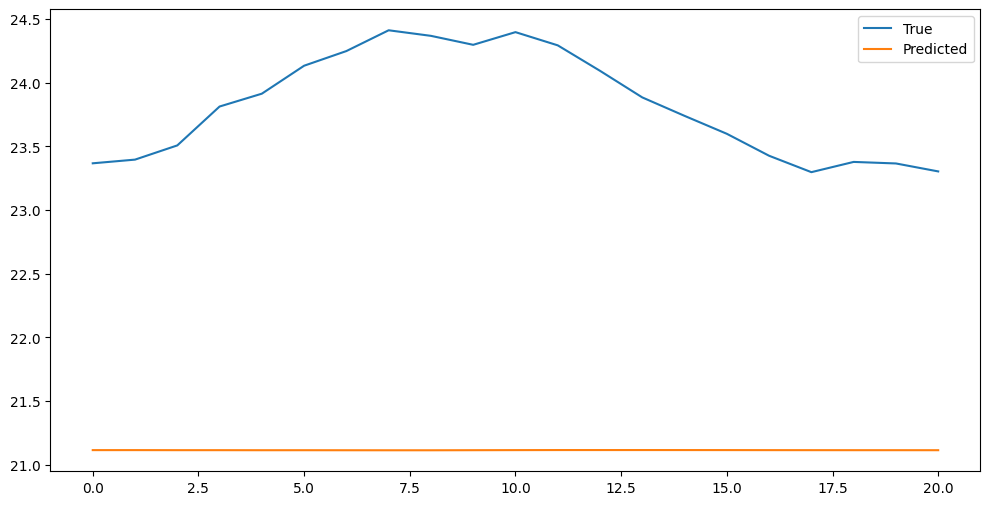

In [186]:
Decoder1.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in train_loader:  # use train_loader instead of test_loader
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)
        y_true.append(y)  # save true labels

# Only keep the last batch
y_pred = y_pred[-1].cpu().numpy()
y_true = y_true[-1].numpy()  # convert true labels to numpy array

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Decoder2 = SimplifiedDecoder(train_data[0][0].shape[1], 128,max_len=train_data[0][0].shape[0],num_heads=4,d_ff=256,device="cpu")

In [ ]:
model.load_state_dict(torch.load("/Users/florian/Documents/github/study/IoT/IoT/main/Decoder_besser.pth"), map_location=torch.device('cpu'))

In [11]:
# Assuming that Decoder1 is an instance of the same class as the original Decoder1
# Correct usage of map_location
Decoder2.load_state_dict(torch.load('Decoder_besser.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

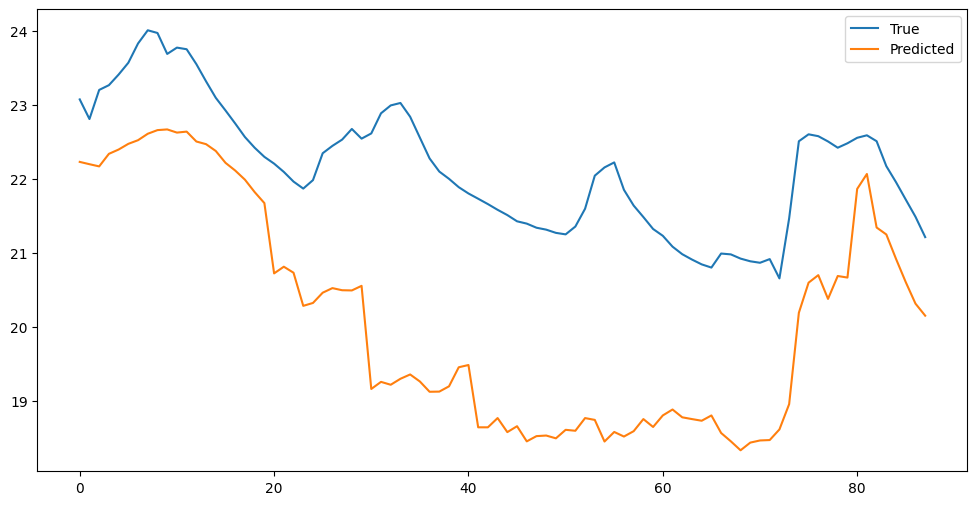

In [13]:
Decoder2.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to("cpu")
        output = Decoder2(x)
        y_pred.append(output)

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
y_true = y_test.numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [120]:
import numpy as np

# Assuming y_test and y_pred are numpy arrays
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print("Correlation:", correlation)

Correlation: -0.012823753812436292


In [179]:
torch.save(Decoder1.state_dict(), 'Decoder_besser.pth')

In [28]:
x.shape

torch.Size([32, 500, 58])

In [188]:
data_loader

In [67]:
d_model = 512
num_heads = 8
multihead_attention = MultiHeadAttention(d_model, num_heads)


batch_size = 64
seq_len = 10
Q = torch.rand(batch_size, seq_len, d_model)
K = torch.rand(batch_size, seq_len, d_model)
V = torch.rand(batch_size, seq_len, d_model)
output, attention = multihead_attention(Q, K, V)

In [69]:
output.shape

torch.Size([64, 10, 512])

In [55]:

scaled_dot_product = ScaledDotProduct()
Q = torch.randn(10, 20, 30)
K = torch.randn(10, 20, 30)
V = torch.randn(10, 20, 40)


output, attention = scaled_dot_product(Q, K, V)

In [63]:
output[0].shape, attention[0].shape

(torch.Size([20, 40]), torch.Size([20, 20]))

In [64]:
attention[0][0]

tensor([0.0163, 0.0329, 0.0278, 0.1355, 0.0135, 0.0550, 0.0034, 0.0812, 0.0678,
        0.0717, 0.0605, 0.0011, 0.0840, 0.1410, 0.0687, 0.0337, 0.0112, 0.0352,
        0.0548, 0.0048])

In [46]:
Decoder = Decoder(data[0][0].shape[1], 25)

In [51]:
data[0][0]

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 25.0800,  44.9700, -16.8000,  ...,   0.0000,   0.0000,   0.0000]])

In [52]:
Decoder.forward(data[0][0]).shape

torch.Size([500, 25])

In [56]:
class TransformerModel(torch.nn.Module):
    """
    Transformer model class
    """
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_len, device, src_pad_idx):
        """
        constructor of TransformerModel class

        :param input_size: input size
        :param d_model: dimension of model
        :param nhead: number of head
        :param num_encoder_layers: number of encoder layer
        :param dim_feedforward: dimension of feedforward
        :param max_len: max sequence length
        :param device: hardware device setting
        :param src_pad_idx: the index of the source padding token
        """
        super(TransformerModel, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.embedding = torch.nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        encoder_norm = torch.nn.LayerNorm(d_model)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        self.fc = torch.nn.Linear(d_model, 1)

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src):
        """
        forward method

        :param src: source input
        :return: output
        """
        src_mask = self.make_src_mask(src)
        src = self.embedding(src)
        src = src + self.pos_encoder(src)

        output = self.transformer_encoder(src, src_key_padding_mask=src_mask.squeeze())
        output = self.fc(output)

        return output

In [53]:

d_model = 512
max_len = 1000
pe = PositonalEncoding(d_model, max_len)
x = torch.zeros((1, max_len, d_model))
output1 = pe.forward(x)
output1

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [-8.9797e-01, -4.4006e-01,  4.2620e-01,  ...,  9.9427e-01,
           1.0317e-01,  9.9466e-01],
         [-8.5547e-01,  5.1785e-01,  9.8628e-01,  ...,  9.9425e-01,
           1.0327e-01,  9.9465e-01],
         [-2.6461e-02,  9.9965e-01,  6.9756e-01,  ...,  9.9424e-01,
           1.0337e-01,  9.9464e-01]]])